In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
import pandas as pd

In [2]:
#Load and Preprocess Data
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load data

dev_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_HW5_LinYu/bobsue.seq2seq.dev.tsv', sep='\t', header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_HW5_LinYu/bobsue.seq2seq.test.tsv', sep='\t', header=None)
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_HW5_LinYu/bobsue.seq2seq.train.tsv', sep='\t', header=None)

print("Data loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.


In [3]:
# Read the vocabulary file into a list
vocab = []
with open('/content/drive/MyDrive/Colab Notebooks/ML_HW5_LinYu/bobsue.voc.txt', 'r') as file:
    for line in file:
        vocab.append(line.strip())

print(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}
vocab_size = len(vocab)

['<s>', '</s>', '.', 'to', 'Bob', 'the', 'was', 'Sue', 'a', 'her', 'and', 'his', 'He', 'he', ',', 'had', 'She', 'she', 'for', 'in', 'it', 'of', "'s", "'t", 'on', 'at', 'day', 'wanted', 'him', 'decided', 'out', 'with', 'up', 'went', 'that', 'got', 'go', 'new', 'The', 'home', 'friends', 'very', 'school', 'one', 'didn', 'not', 'all', 'get', 'they', 'but', 'His', 'friend', 'time', 'would', 'They', 'so', 'were', 'When', 'work', 'Her', 'asked', 'dog', 'car', 'house', 'from', 'told', 'But', '!', 'mom', 'could', 'loved', 'One', 'store', 'It', 'mother', 'be', 'have', 'took', 'them', 'about', 'as', 'found', 'did', 'first', 'money', 'needed', 'night', 'play', 'bought', 'going', 'an', 'job', 'there', 'saw', 'back', 'parents', 'game', 'buy', 'when', 'never', 'over', 'been', 'into', 'really', 'made', 'couldn', 'some', 'class', 'see', 'too', 'said', 'what', 'no', 'good', 'came', 'family', 'do', 'is', 'dad', 'take', 'started', 'phone', 'down', 'called', 'always', 'how', 'happy', 'thought', 'find', 'ne

In [4]:
from torch.utils.data import DataLoader, Dataset
# Tokenize sentences and convert words to indices
def tokenize(sentence):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

class SentenceDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.applymap(tokenize)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, 0]), torch.tensor(self.data.iloc[idx, 1])

train_dataset = SentenceDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

dev_dataset = SentenceDataset(dev_data)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

test_dataset = SentenceDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# New Section

Reference:https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [5]:

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Initialize weights and biases for the input gate
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_i = nn.Parameter(torch.randn(hidden_size))

        # Initialize weights and biases for the forget gate
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_f = nn.Parameter(torch.randn(hidden_size))

        # Initialize weights and biases for the cell state update
        self.W_c = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_c = nn.Parameter(torch.randn(hidden_size))

        # Initialize weights and biases for the output gate
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.b_o = nn.Parameter(torch.randn(hidden_size))

        # Fully connected layer to map hidden state to output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # Ensure hidden and cell states have the same dimension as input
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(0)
        if cell.dim() == 2:
            cell = cell.unsqueeze(0)

        # Concatenate input and hidden state along the last dimension
        combined = torch.cat((x, hidden), 2)

        # Input gate: decides which values from input to update the cell state
        i_t = torch.sigmoid(torch.matmul(combined, self.W_i.t()) + self.b_i)

        # Forget gate: decides which part of the cell state to keep
        f_t = torch.sigmoid(torch.matmul(combined, self.W_f.t()) + self.b_f)

        # Output gate: decides which part of the cell state to output
        o_t = torch.sigmoid(torch.matmul(combined, self.W_o.t()) + self.b_o)

        # Candidate cell state: new cell state values to be added
        c_tilde = torch.tanh(torch.matmul(combined, self.W_c.t()) + self.b_c)

        # Update the cell state
        cell = f_t * cell + i_t * c_tilde

        # Compute the hidden state
        hidden = o_t * torch.tanh(cell)

        # Compute the output
        output = self.fc(hidden)

        return output, hidden, cell


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, data_loader, num_epochs, learning_rate, embeddings, vocab_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for inputs, targets in data_loader:
            hidden = torch.zeros(1, model.hidden_size)
            cell = torch.zeros(1, model.hidden_size)

            optimizer.zero_grad()

            loss = 0
            for input_idx, target_idx in zip(inputs[0], targets[0]):
                input_vector = embeddings(input_idx).unsqueeze(0).unsqueeze(0)
                target_vector = embeddings(target_idx).unsqueeze(0).unsqueeze(0)

                output, hidden, cell = model(input_vector, hidden, cell)
                loss += criterion(output, target_vector)

                # Calculate accuracy
                _, predicted_idx = torch.max(output, dim=2)
                _, target_idx_max = torch.max(target_vector, dim=2)
                correct_predictions += (predicted_idx == target_idx_max).sum().item()
                total_predictions += target_idx_max.nelement()

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        accuracy = correct_predictions / total_predictions

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}')

    return train_losses, train_accuracies

# Assuming CustomLSTM is defined somewhere and train_loader is available
embedding_dim = 200
embeddings = nn.Embedding(vocab_size, embedding_dim)

input_size = embedding_dim
hidden_size = 200
output_size = embedding_dim

model = CustomLSTM(input_size, hidden_size, output_size)
train_losses, train_accuracies = train(model, train_loader, num_epochs=10, learning_rate=0.001, embeddings=embeddings, vocab_size=vocab_size)


Epoch 1, Loss: 8.92660713811992, Accuracy: 0.13843268368262251
Epoch 2, Loss: 8.858110549001207, Accuracy: 0.14531517573187638
Epoch 3, Loss: 8.843072453384133, Accuracy: 0.14679931501263965
Epoch 4, Loss: 8.829176329831716, Accuracy: 0.14738644703579876
Epoch 5, Loss: 8.811326242188414, Accuracy: 0.14968604745983854
Epoch 6, Loss: 8.796891221587748, Accuracy: 0.15048519938024954
Epoch 7, Loss: 8.781239560023296, Accuracy: 0.15322514882165864
Epoch 8, Loss: 8.767430770073291, Accuracy: 0.1534697871646416
Epoch 9, Loss: 8.751904478919988, Accuracy: 0.15286634591861697
Epoch 10, Loss: 8.737389310888299, Accuracy: 0.15306205659300334


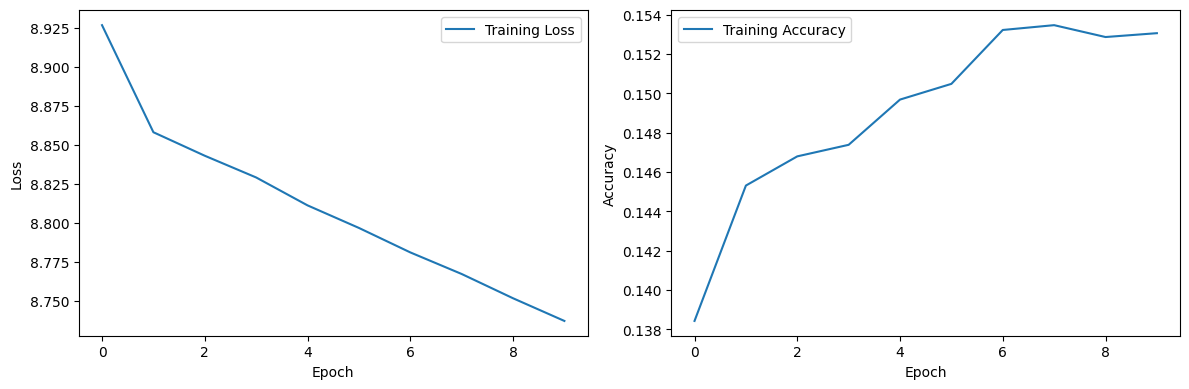

In [9]:
import matplotlib.pyplot as plt
# Plot the training loss and training accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize random embeddings
embedding_weights = torch.rand(vocab_size, embedding_dim)
# Set the random embeddings to the embedding layer
embeddings.weight = nn.Parameter(embedding_weights)

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Initialize hidden and cell states with zeros
            hidden = torch.zeros(1, model.hidden_size)
            cell = torch.zeros(1, model.hidden_size)

            loss = 0
            correct_predictions = 0
            total_predictions_batch = 0

            sequence_length = inputs.size(1)
            for i in range(sequence_length):
                if i < targets.size(1):  # Ensure target index is within bounds
                    # Convert input indices to embedding vectors
                    input_vector = embeddings(inputs[:, i]).unsqueeze(1)
                    # Convert target indices to embedding vectors
                    target_vector = embeddings(targets[:, i]).unsqueeze(1)

                    # Forward pass through the model
                    output, hidden, cell = model(input_vector, hidden, cell)
                    # Calculate the L2 norm loss between output and target
                    loss += torch.norm(output - target_vector).item()

                    # Calculate accuracy
                    _, predicted_idx = torch.max(output, dim=2)
                    _, target_idx = torch.max(target_vector, dim=2)
                    correct_predictions += (predicted_idx == target_idx).sum().item()
                    total_predictions_batch += target_idx.nelement()

            # Accumulate the loss and accuracy for the current batch
            total_loss += loss
            total_correct += correct_predictions
            total_predictions += total_predictions_batch

    # Calculate and print the average loss and accuracy over the data loader
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_predictions
    print(f'Average Loss: {avg_loss}, Accuracy: {accuracy}')

# Evaluate the model on the test data
evaluate(model, test_loader)


Average Loss: 89.37202928543091, Accuracy: 0.006053428082642453


In [21]:
import torch

def generate_predictions(model, data_loader, output_file):
    # Set the model to evaluation mode
    model.eval()
    predictions = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, _ in data_loader:
            # Initialize hidden and cell states with zeros
            hidden = torch.zeros(1, model.hidden_size)
            cell = torch.zeros(1, model.hidden_size)

            sentence_prediction = []
            # Iterate over the sequence length
            for i in range(inputs.size(1)):
                # Convert input indices to embedding vectors
                input_vector = embeddings(inputs[:, i]).unsqueeze(1)
                # Forward pass through the model
                output, hidden, cell = model(input_vector, hidden, cell)

                # Find the index of the word closest to the output vector
                predicted_word_index = torch.argmin(torch.norm(embeddings.weight - output, dim=1)).item()
                # Append the predicted word to the sentence prediction
                sentence_prediction.append(index_to_word[predicted_word_index])

            # Append the sentence prediction to the predictions list
            predictions.append(" ".join(sentence_prediction))

    # Write predictions to the output file
    with open(output_file, 'w') as f:
        for prediction in predictions:
            f.write(prediction + '\n')

# Generate predictions and save them to a file
generate_predictions(model, test_loader, '/content/drive/MyDrive/Colab Notebooks/ML_HW5_LinYu/predictions.txt')
